In [ ]:
import csv
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import re
import seaborn as sns
import scipy
import sys

# from scipy.special import entr
from scipy.stats import norm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from nltk.corpus import stopwords

from keras.callbacks import ModelCheckpoint
# from keras.preprocessing.sequence import pad_sequences
# from keras.layers import Dropout
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Embedding, Dropout
from keras.models import Sequential
from keras.utils import np_utils

In [ ]:
# Needed functions for processing the data.

def clean_review(text):
    '''
    Function to clean text data.
    '''
    # Strip HTML tags
    text = re.sub('<[^<]+?>', ' ', text)
 
    # Strip escaped quotes
    text = text.replace('\\"', '')
 
    # Strip quotes
    text = text.replace('"', '')
    
    # Strip @
    text = text.replace('@', '')
 
    return text


def to_sequence(tokenizer, preprocessor, index, text):
    '''
    Puts words into a onehot embedding for the ML models ... I think.
    '''
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    
    return indexes


def shuffle(X, y):
    '''
    Shuffle the data function.
    '''
    perm = np.random.permutation(len(X))
    X = X[perm]
    y = y[perm]
    
    return X, y


def convert_to_int(data):
    '''
    This will convert all data inside a list into integers.
    '''
    for i in range(0, len(data)):
        try:
            data[i] = int(data[i])
        except:
            data[i] = int(data[i][0])

    return data


def convert_to_one_hot(data):
    '''
    This takes an input vector of values in the range 0-N or in strings and turns
    them into onehot encoded vectors. Used for output labels in multi-class classification.
    '''
    encoder = LabelEncoder()
    encoder.fit(data)
    encoded_data = encoder.transform(data)

    return np_utils.to_categorical(encoded_data)


def add_padding(data, extra_pad=0):
    '''
    This will add padding to the data inside the list.
    It will make each element the same length.
    Extra padding can be added by using extra_pad.
    '''
    max_length = 0
    try:
        for i in range(0, len(data)):
            if len(data[i]) > max_length:
                max_length = len(data[i])
    except:
#         This except handles the case when there is only one datapoint
        max_length = len(data)
        needed_padding = max_length + extra_pad
        padding = [0] * needed_padding
        try:
            data[i] = data[i] + padding
        except:
            data[i] = [data[i]] + padding
        return data
    
    for i in range(0, len(data)):
        text_length = len(data[i])
        needed_padding = max_length - text_length + extra_pad
        padding = [0] * needed_padding
        try:
            data[i] = data[i] + padding
        except:
            data[i] = [data[i]] + padding

    return data

In [19]:
# This is data preperation for the model.

def data_sequences(input_data, outputs):
    input_data_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in input_data]
    sequence_length = len(max(input_data_sequences, key=len))
    input_data_sequences = add_padding(input_data_sequences, extra_pad=0)

    X_train, X_test, y_train, y_test = train_test_split(input_data_sequences, outputs, test_size=0.1, random_state=73)

    # Need to turn string values to integer values for the model
    y_train = convert_to_int(y_train)
    y_test = convert_to_int(y_test)
    
    return X_train, X_test, y_train, y_test, sequence_length

# Function to build the CNN model for binary sentiment classification.
def CNN_model_sentiment(length_seq):
    model = Sequential()
    model.add(Embedding(len(vectorizer.get_feature_names()) + 1,
                        64,  # Embedding size
                        input_length=length_seq))
    model.add(Conv1D(64, 5, activation='relu'))
    # model_my_v1_combined.add(MaxPooling1D(5))
    model.add(Conv1D(64, 5, activation='relu'))
    # model_my_v1_combined.add(MaxPooling1D(5))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    print('number of layers = ', len(model.layers))
    return model


# Function to build the CNN model for multi-class classification.
def CNN_model_classification(length_seq):
    '''
    This model is the same as the model for sentiment classification except for two
    lines marked below.  Sentiment is binary classifcation with 1 output so the sigmoid
    function can be used.  Classifiying to three classes used categorical cross entropy
    This model will have out put a a 3x1 vector which uses the softmax activation function.
    This is so all output values sum to 1 which yield probabilities.
    '''
    model = Sequential()
    model.add(Embedding(len(vectorizer.get_feature_names()) + 1,
                        64,  # Embedding size
                        input_length=length_seq))
    model.add(Conv1D(64, 5, activation='relu'))
    # model_my_v1_combined.add(MaxPooling1D(5))
    model.add(Conv1D(64, 5, activation='relu'))
    # model_my_v1_combined.add(MaxPooling1D(5))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=3, activation='softmax'))   # modified line 1

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # modified line 2
    print(model.summary())
    print('number of layers = ', len(model.layers))
    return model


def train_model(model, X_train, y_train, size_batch=50, num_epochs=2):
    print('Starting to train the model.')
    for i in range(0, num_epochs):
        history = model.fit(X_train[:-100], y_train[:-100], 
                  epochs=num_epochs, batch_size=size_batch, verbose=1,
                  validation_data=(X_train[-100:], y_train[-100:]))
    return history


def new_text_to_sequence(input_data, proper_model_length):
    '''
    proper_model_length is the length of the sequence array for each model.
    '''
    input_data_sequence = [to_sequence(tokenize, preprocess, word2idx, x) for x in input_data]
    input_data_sequence = input_data_sequence[0]
    sequence_length = proper_model_length - len(input_data_sequence)
    if sequence_length >= 0:
        input_data_sequence = add_padding(input_data_sequence, extra_pad=sequence_length - 1)
    else:
        input_data_sequence = input_data_sequence[0:proper_model_length]
        print(f'Input text too long. It was clipped by {abs(sequence_length)} values.')
    return input_data_sequence

def sentiment_label(data):
    if data > .5:
        print('The sentiment was positive.')
    else:
        print('The sentiment was negative.')

In [ ]:
# Data processing for news dataset.
# News cell 1/4

# This is the data set that throws the error below.
# 'utf-8' codec can't decode byte 0x96 in position 37: invalid start byte
# need the latin-1 encoding argument in the pd.read_csv line.
# The allImdb and tweets dataset seem not to need any modification.

path = '/Users/AJApple/Downloads/'
data_news = []
with open(path + 'world_news_in_month_cleaned_2_columsw.csv', 'rt', encoding='latin-1', newline='') as src:
    reader_news = csv.reader(src, dialect='excel', lineterminator='\n')
    for row in reader_news:
        data_news.extend(row)

# Start index at 2 to skip over labels.
data_sentence_news = []
data_sentiment_news = []

index = 0
for i in range(0, len(data_news)):
    if (i % 2) == 0:
        data_sentence_news.append(data_news[index])
    else:
        data_sentiment_news.append([data_news[index]])
    index += 1

news_sentiment = data_sentiment_news
news_text = []
for row in range(0, len(data_sentence_news)):
    news_text.append(clean_review(data_sentence_news[row]))
    
# From this cell there are two out put vectors one for the input text called:
#     news_text
# and one for the sentiment i.e. label/output called:
#     news_sentiment

In [ ]:
# News Cell 2/4

# Sanity check cell to make sure data is correct. This should be checked with the 
# origional csv file data. (It checks out.)

a = 52428  # check with random index values
print(data_sentence_news[a])
print(data_sentiment_news[a])
print(news_text[a])
print(news_sentiment[a])

In [ ]:
# News Cell 3/4

# Analysis of news (of cleaned data).
global_sentence_news = []
unique_word_count_news = 0
word_count_news = 0
sentence_lengths_array_news = []

for i in range(0, len(news_text)):
    sentence = list(news_text[i].split())
    word_count_news += len(sentence)
    global_sentence_news.extend(sentence)  # need to use extend not append
    sentence_lengths_array_news.extend([len(sentence)])

# Some dataset statistics.

total_sentences_news = len(news_text)
print('Total number of sentences = ', total_sentences_news)

# To get unique word count use set theory.
unique_word_count_news = len(set(global_sentence_news))
print('Unique word count news = ', unique_word_count_news)

# To get total counts.
print('Total word count = ', word_count_news)

# Some ratios calculated from the data.
print('Unique to total word count of news metric = ', unique_word_count_news / word_count_news)
print('Unique word to number of sentences news metric = ', unique_word_count_news / total_sentences_news)

# Fit a normal distribution to the data:
mu_news, std_news = norm.fit(sentence_lengths_array_news)

/Users/AJApple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


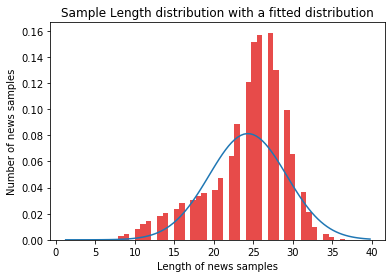

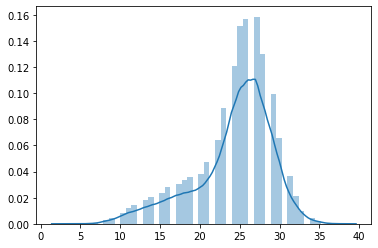

In [8]:
# News Cell 4/4

# Plot the histogram
plt.hist(sentence_lengths_array_news, 50, normed=True, color=[231/255,75/255,74/255])

# Plot the PDF.
# Note there are two distributions fit to the data. The first is a Gaussian and
# the second in non-parametric formed by overlapping kernels.

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mu_news, std_news)
plt.plot(x, y)
plt.xlabel('Length of news samples')
plt.ylabel('Number of news samples')
plt.title('Sample Length distribution with a fitted distribution')
plt.show()
sns.distplot([sentence_lengths_array_news])  # seaborn plot

In [9]:
# Data processing for allImdb dataset.
# allImdb Cell 1/4

path = '/Users/AJApple/Downloads/'
data_allImdb = []
reader_allImdb = csv.reader(open(path + 'IMDB_dataset_2.csv'), delimiter=',')
for row in reader_allImdb:
    data_allImdb.extend(row)

# Create empty lists to hold the sentences and sentiment data.
# These lists contain all the data. The data will still need to get shuffled and split
# into traing and test.
data_sentence_allImdb = []
data_sentiment_allImdb = []

index = 0
for i in range(0, len(data_allImdb)):
    if (i % 2) == 0:
        data_sentence_allImdb.append(data_allImdb[index])
    else:
        data_sentiment_allImdb.append([data_allImdb[index]])
    index += 1

imdb_sentiment = []
for i in range(0, len(data_sentiment_allImdb)):
    if data_sentiment_allImdb[i] == ['positive']:
        imdb_sentiment.append(1)
    else:
        imdb_sentiment.append(0)

imdb_text = []
# Clean the sentence data i.e. removing html tags, ... etc.
for row in range(0, len(data_sentence_allImdb)):
    imdb_text.append(clean_review(data_sentence_allImdb[row]))
    
# From this cell there are two out put vectors one for the input text called:
#     imdb_text
# and one for the sentiment i.e. label/output called:
#     imdb_sentiment

In [10]:
# allImdb Cell 2/4

# Sanity check cell to make sure data is correct. This should be checked with the 
# origional csv file data. (It checks out.)

a = 49989  # check with random index values
print(data_sentence_allImdb[a])
print(data_sentiment_allImdb[a])
print(imdb_text[a])
print(imdb_sentiment[a])

I got this one a few weeks ago and love it! It's modern, light but filled with true complexities of life. It questions and answers, just like other Eytan Fox movies. This is my favorite, along with Jossi & Jagger. This pictures a lot more, universally, than only the bubbles we may live in. You don't need to be Jewish or homosexual to enjoy this - I'm not, but the movie goes directly to my top ten movies. At first it seems like pure entertainment but it does make you think further. Relationships we have to live with are superficial, meaningful, deep, fatal, you name it. You don't know what's coming, and you definitely don't know where this story is heading as you watch it the first time. It is worth seeing several times. Fox movies include great bonus material - here a great music video and "the making of" (including explanation of the title, interviewing Lior Ashknenazi who plays himself in the movie and Arabs with doubts about the Israeli life styles).
['positive']
I got this one a fe

In [11]:
# Analysis of allImdb (of cleaned data).
# Cell 3/4

global_sentence_allImdb = []
unique_word_count_allImdb = 0
word_count_allImdb = 0
sentence_lengths_array_allImdb = []

for i in range(0, len(imdb_text)):
    sentence = list(imdb_text[i].split())
    word_count_allImdb += len(sentence)
    global_sentence_allImdb.extend(sentence)
    sentence_lengths_array_allImdb.extend([len(sentence)])

# Some dataset statistics.

total_sentences_allImdb = len(imdb_text)
print('Total number of sentences = ', total_sentences_allImdb)

# To get unique word count use set theory.
unique_word_count_allImdb = len(set(global_sentence_allImdb))
print('Unique word count allImdb = ', unique_word_count_allImdb)

# To get total counts.
print('Total word count allImdb = ', word_count_allImdb)

# Some ratios calculated from the data.
print('Unique to total word count of allImdb metric = ', unique_word_count_allImdb / word_count_allImdb)
print('Unique word to number of sentences allImdb metric = ', unique_word_count_allImdb / total_sentences_allImdb)

# Fit a normal distribution to the data:
mu_allImdb, std_allImdb = norm.fit(sentence_lengths_array_allImdb)

Total number of sentences =  50000
Unique word count allImdb =  379104
Total word count allImdb =  11442730
Unique to total word count of allImdb metric =  0.03313055538319964
Unique word to number of sentences allImdb metric =  7.58208


/Users/AJApple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


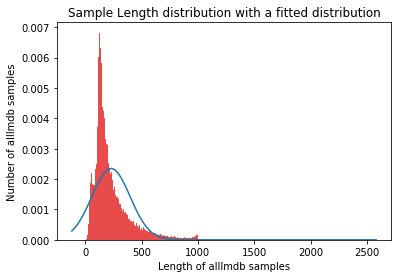

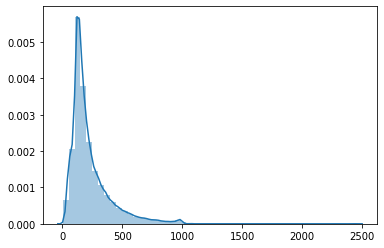

In [12]:
# allImdb  Cell 4/4

# Plot the histogram
plt.hist(sentence_lengths_array_allImdb, 'auto', normed=True, color=[231/255,75/255,74/255])

# Plot the PDF.
# Note there are two distributions fit to the data. The first is a Gaussian and
# the second in non-parametric formed by overlapping kernels.

# The next four lines will plot a gaussian ... 
xmin_allImdb, xmax_allImdb = plt.xlim()
x_allImdb = np.linspace(xmin_allImdb, xmax_allImdb, 100)
y_allImdb = norm.pdf(x_allImdb, mu_allImdb, std_allImdb)
plt.plot(x_allImdb, y_allImdb)

# The next lines plot using seaborn
plt.xlabel('Length of allImdb samples')
plt.ylabel('Number of allImdb samples')
plt.title('Sample Length distribution with a fitted distribution')
plt.show()
sns.distplot([sentence_lengths_array_allImdb])

In [13]:
# To get data use csv reader cause pandas not working properly.
# tweets Cell 1/4

path = '/Users/AJApple/Downloads/tweet-sentiment-extraction/'
data_tweets = []
reader = csv.reader(open(path + 'train_2_columns.csv'), delimiter=',')
for row in reader:
    data_tweets.extend(row)

data_sentence_tweets = []
data_sentiment_tweets = []

index = 0
for i in range(0, len(data_tweets)):
    if (i % 2) == 0:
        data_sentence_tweets.append(data_tweets[index])
    else:
        data_sentiment_tweets.append([data_tweets[index]])
    index += 1

tweets_sentiment = []
for i in range(0, len(data_sentiment_tweets)):
    if data_sentiment_tweets[i] == ['positive']:
        tweets_sentiment.append(1)
    elif data_sentiment_tweets[i] == ['negative']:
        tweets_sentiment.append(0)
    else:
        tweets_sentiment.append(2)
        
tweets_text = []
for row in range(0, len(data_sentence_tweets)):
    tweets_text.append(clean_review(data_sentence_tweets[row]))
    

# Now need to remove all the neutral elements

index = 0
while True:
    if tweets_sentiment[index] == 2:
        tweets_text.remove(tweets_text[index])
        tweets_sentiment.remove(tweets_sentiment[index])
        index -= 1
    index += 1
    if index == len(tweets_text):
        break
        
# From this cell there are two out put vectors one for the input text called:
#     tweets_text
# and one for the sentiment i.e. label/output called:
#     tweets_sentiment

In [14]:
# tweets Cell 2/4

# Sanity check cell to make sure data is correct. This should be checked with the 
# origional csv file data. (It checks out.)

a = -1
print(tweets_text[a])
print(tweets_sentiment[a])

 But it was worth it  ****.
1


In [15]:
# Analysis of tweets (of cleaned data)
# Cell 3/4

global_sentence_tweets = []
unique_word_count_tweets = 0
word_count_tweets = 0
sentence_lengths_array_tweets = []

for i in range(0, len(tweets_text)):
    sentence = list(tweets_text[i].split())
    word_count_tweets += len(sentence)
    global_sentence_tweets.extend(sentence)
    sentence_lengths_array_tweets.extend([len(sentence)])

    
# Some dataset statistics

total_sentences_tweets = len(tweets_text)
print('Total number of sentences = ', total_sentences_tweets)

# To get unique word count use set theory.
unique_word_count_tweets = len(set(global_sentence_tweets))
print('Unique word count tweets = ', unique_word_count_tweets)

# Total get total word count.
print('Total word count = ', word_count_tweets)

# Some ratios calculated from the data
print('Unique to total word count metric = ', unique_word_count_tweets / word_count_tweets)
print('Unique word to number of sentences metric = ', unique_word_count_tweets / total_sentences_tweets)

# Fit a normal distribution to the sentence lengths:
mu_tweets, std_tweets = norm.fit(sentence_lengths_array_tweets)

Total number of sentences =  16363
Unique word count tweets =  35706
Total word count =  217221
Unique to total word count metric =  0.16437637245017747
Unique word to number of sentences metric =  2.182118193485302


/Users/AJApple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


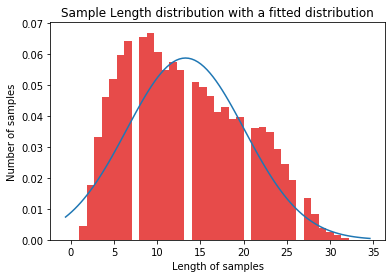

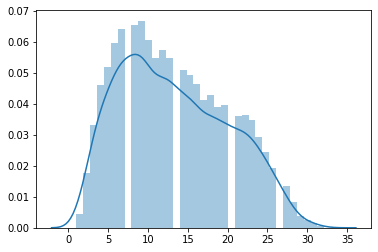

In [16]:
# tweets Cell 4/4

# Plot the histogram
plt.hist(sentence_lengths_array_tweets, 'auto', normed=True, color=[231/255,75/255,74/255])

# Plot the PDF.
# Note there are two distributions fit to the data. The first is a Gaussian and
# the second in non-parametric formed by overlapping kernels.

# The next four lines will plot a gaussian
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mu_tweets, std_tweets)
plt.plot(x, y)

# Plotting using seaborn
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample Length distribution with a fitted distribution')
plt.show()
sns.distplot([sentence_lengths_array_tweets])

In [17]:
# Combine all the data from the three data sets.

combined_text = news_text + imdb_text + tweets_text
combined_sentiment = news_sentiment + imdb_sentiment + tweets_sentiment

In [18]:
# This next part has to be once for all the data. It is the function to vectorize the words.

vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), 
                             lowercase=True, min_df=3, max_df=0.9, max_features=5000)

vectorizer.fit_transform(combined_text)

word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()
# print(f'This is is list of all the features in dictionary: {vectorizer.get_feature_names()}')

There are now 4 types of data: news, imdb, tweets, and combimed.<br>
Each dataset has inputs i.e. text, and labels i.e. sentiment scores.  This gives a total
of 8 data vectors we will be using.<br> 
i.e. 4 data types * 2 = 8<br>
The 'combined' will be for classication of input string type and 'news, imdb, and tweets'
will be for sentiment classification.


Now can start the CNN model<br>

There are 4 varibles that will be used in the modelling at this point:<br>
    X_train<br>
    X_test<br>
    y_train<br>
    y_test

In [ ]:
# This will construct the model for the combined data which will classify the type of text.

# This creates a list of values for each of the dataset classes we have.  Since we have three
# datasets we will have three labels or categories that will need to be classified.
# When a new text string first comes into this system it is classified as either a news, imdb, or
# tweets.  Then depending on the classification of these three categories, the corresponding
# sentiment model will be used.

news_labels = [0] * len(news_sentiment)
imdb_labels = [1] * len(imdb_sentiment)
tweets_labels = [2] * len(tweets_sentiment)
combined_labels = news_labels + imdb_labels + tweets_labels
X_train_category, X_test_category, y_train_category, y_test_category, length_category = data_sequences(combined_text, combined_labels)

# Convert integer labels into one-hot vectors for multi-class classification
y_train_category = convert_to_one_hot(y_train_category)
y_test_category = convert_to_one_hot(y_test_category)

combined_classification = CNN_model_classification(length_category)

# Need to inputs turn into a numpy array or model will not work
X_train_category = np.array(X_train_category)
X_test_category = np.array(X_test_category)

classification_history = train_model(combined_classification, X_train_category, y_train_category)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 914, 64)           320064    
_________________________________________________________________
conv1d (Conv1D)              (None, 910, 64)           20544     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 906, 64)           20544     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 902, 64)           20544     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 180, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 11520)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                7

In [ ]:
# This will construct the model for the news data.

X_train_news, X_test_news, y_train_news, y_test_news, length_news = data_sequences(news_text, news_sentiment)

news_CNN = CNN_model_sentiment(length_news)

news_history = train_model(news_CNN, X_train_news, y_train_news)

In [ ]:
# This will construct the model for the imdb data.

X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb, length_imdb = data_sequences(imdb_text, imdb_sentiment)

imdb_CNN = CNN_model_sentiment(length_imdb)

imdb_history = train_model(imdb_CNN, X_train_imdb, y_train_imdb)

In [ ]:
# This will construct the model for the tweets data.

X_train_tweets, X_test_tweets, y_train_tweets, y_test_tweets, length_tweets = data_sequences(tweets_text, tweets_sentiment)

tweets_CNN = CNN_model_sentiment(length_tweets)

tweets_history = train_model(tweets_CNN, X_train_tweets, y_train_tweets)

In [ ]:
news_scores = news_CNN.evaluate(X_test_news, y_test_news, verbose=1)

In [ ]:
imdb_scores = imdb_CNN.evaluate(X_test_imdb, y_test_imdb, verbose=1)

In [ ]:
tweets_scores = tweets_CNN.evaluate(X_test_tweets, y_test_tweets, verbose=1)

In [ ]:
# 
# 
# 
# Now that all the models are built the pipline for input text to proper model
# can be constructed.
# 
# 
# 

In [ ]:
# This part will simulate running the above models.

print('This part will simulate running the above models. Keybord input is required.')
exit_program = False
while True:
    if exit_program == True:
        break
    print('Do you want to test the model by typing in input string. Enter y or n.')
    console_text = input()
    console_text = console_text.lower()

    if console_text == 'y':
        print('You have choosen to continue this progam. Enter q to terminate program.')
        print('Enter the text string that you want to check for sentiment. \nIt can be up to 1000 words.')
        while True:
            print('Enter string now.')
            console_text = [input()]
            if console_text == 'q' or console_text == ['q']:
                exit_program = True
                break
            sent_to_score = new_text_to_sequence(console_text, length_category)
            model_number = np.argmax(combined_classification.predict(sent_to_score[:1]))
            if model_number == 0:
                sent_to_score = new_text_to_sequence(console_text, length_news)
                print(f'The sentiment score is: {news_CNN.predict(sent_to_score[:1])}')
                sentiment_label(news_CNN.predict(sent_to_score[:1]))
            elif model_number == 1:
                sent_to_score = new_text_to_sequence(console_text, length_imdb)
                print(f'The sentiment score is: {imdb_CNN.predict(sent_to_score[:1])}')
                sentiment_label(imdb_CNN.predict(sent_to_score[:1]))
            elif model_number == 1:
                sent_to_score = new_text_to_sequence(console_text, length_tweets)
                print(f'The sentiment score is: {tweets_CNN.predict(sent_to_score[:1])}')
                sentiment_label(tweets_CNN.predict(sent_to_score[:1]))
            else:
                print('An error happened with the model or input string. Try another value\nand check type.')        
    elif console_text == 'n':
        print('You have choosen to terminate this progam ... exiting now.')
        break
    else:
        print('You typed in something incorrect.  Re-run the cell.')
        break

In [ ]:
# 
# 
# 
# Unused code but keep for the time being
# 
# 
# 

In [ ]:
# This will test the model on random input string of our choosing.  These are the commands 
# that are used to test the models on random input strings.

test_to_score = ['I am very very very happy that I came home to you. Now we can enjoy the sun.']

sent_to_score = new_text_to_sequence(test_to_score, length_news)
print(f'This is the output of the sentiment models: {news_CNN.predict(sent_to_score[:1])}')

# sent_to_score = new_text_to_sequence(test_to_score, length_imdb)
# imdb_CNN.predict(sent_to_score[:1])

# sent_to_score = new_text_to_sequence(test_to_score, length_tweets)
# tweets_CNN.predict(sent_to_score[:1])

sent_to_score = new_text_to_sequence(test_to_score, length_category)
print(f'This is the output of the sentence classification model: {combined_classification.predict(sent_to_score[:1])}')

In [ ]:
input_string = ['I am very very very happy that I came home to you. Now we can enjoy the sun.']

sent_to_score = new_text_to_sequence(input_string, length_category)
model_number = np.argmax(combined_classification.predict(sent_to_score[:1]))

if model_number == 0:
    sent_to_score = new_text_to_sequence(input_string, length_news)
    news_CNN.predict(sent_to_score[:1])
elif model_number == 1:
    sent_to_score = new_text_to_sequence(input_string, length_imdb)
    imdb_CNN.predict(sent_to_score[:1])
elif model_number == 1:
    sent_to_score = new_text_to_sequence(input_string, length_tweets)
    tweets_CNN.predict(sent_to_score[:1])
else:
    print('An error happened with the model or input string. Try another value\nand check type.')